# Tutorial 2: Convergence tests

Let us create a function that given a number of cells N, the finite element order p and
the analytical solution, computes the approximated finite element solution. It is pretty
much the Poisson driver.

I just make a comment about the fact that the computation of the error requires a more
accurate quadrature than for the finite element part. Otherwise, we would make an error in
the computation of the error that would polute the convergence orders.

In [1]:
using Gridap
using Plots
using Test

function compute_solution(N,order,u)

  f(x) = - Δ(u)(x)

  domain = (0,1)
  partition = (N,)
  model = CartesianDiscreteModel(domain,partition)
  trian = get_triangulation(model)

  degree = (order-1)*2
  quad = CellQuadrature(trian,degree)

  V = TestFESpace(
  model=model,
  order=order,
  reffe=:Lagrangian,
  valuetype=Float64,
  dirichlet_tags="boundary")
  U = TrialFESpace(V,u)

  a(u,v) = inner(∇(u),∇(v))
  l(v) = inner(v,f)

  t_Ω = AffineFETerm(a,l,trian,quad)

  op = AffineFEOperator(U,V,t_Ω)

  uh = solve(op)

  sh1(w) = a(w,w)
  h1(w) = sh1(w)

  e = u - uh

  super_quad = CellQuadrature(trian,degree*4)
  eh1 = sqrt(sum( integrate(h1(e),trian,super_quad) ))

  return uh, eh1
end #function

compute_solution (generic function with 1 method)

Now, let us create another function that performs h and p-refinement.
It includes an external loop in which we increase the order and an internal
loop in which, for every order, runs the problem for different cell numbers.
We must provide the set of orders and number of cells we want to explore
in `ps` and `ncells` and the analytical solution we want for our problem.
It returns three arrays of arrays, that include for every order the values
for every number of cells for the following quantities: error in H1 seminorm,
number of dofs and the finite element solution.

In [2]:
function hp_refinement(u,ps,ncells)

  eh1s_hp = []
  ndofs_hp = []
  uhs_hp = []

  for p in ps

    eh1s_h = Float64[]
    ndofs_h = Float64[]
    uhs_h = []

    for N in ncells

      uh, eh1 = compute_solution(N,p,u)
      push!(uhs_h,uh)
      push!(eh1s_h,eh1)

      ndof = Float64(N*p)
      push!(ndofs_h,ndof)

    end

    push!(eh1s_hp,eh1s_h)
    push!(ndofs_hp,ndofs_h)
    push!(uhs_hp,uhs_h)

  end

  return eh1s_hp, ndofs_hp, uhs_hp

end

hp_refinement (generic function with 1 method)

The following function is for printing the finite element solutions but you do not
have to understand the details. Please skip it.

In [3]:
using Gridap.Geometry
using Gridap.ReferenceFEs
using Gridap.Arrays
using Gridap.Visualization
using Gridap.Visualization: VisualizationGrid, _prepare_cdata, _prepare_pdata
using Plots

function visualization_data(trian::Triangulation, order, cellfields)
  f = (reffe) -> UnstructuredGrid(LagrangianRefFE(Float64,get_polytope(reffe),order))
  ref_grids = map(f, get_reffes(trian))
  visgrid = VisualizationGrid(trian,ref_grids)
  cdata = _prepare_cdata(Dict(),visgrid.sub_cell_to_cell)
  pdata = _prepare_pdata(trian,cellfields,visgrid.cell_to_refpoints)
  visgrid, cdata, pdata
end

function plot_data_for_1d_fe_function(trian,uh,order)
  visgrid, cdata, pdata = visualization_data(trian,order,["uh"=>uh])
  x = apply(x->x[1], get_node_coordinates(visgrid))
  y = pdata["uh"]
  p = sortperm(x)
  return x[p], y[p]
end

function plot_uhs(uhs,ps,ncells)
  X      = Vector{Float64}[]
  Y      = Vector{Float64}[]
  labels = String[]
  for (i,p) in enumerate(ps)
    for (j,N) in enumerate(ncells)
        domain = (0,1)
        partition = (N,)
        model = CartesianDiscreteModel(domain,partition)
        trian = get_triangulation(model)
        x,y = plot_data_for_1d_fe_function(trian,uhs[i][j],p)
        push!(X,x)
        push!(Y,y)
        push!(labels, "p=$(p) N=$(N)")
    end
  end
  plot(X[1],Y[1],label=labels[1],shape=:auto)
  for i=2:length(X)
   plot!(X[i],Y[i],label=labels[i],shape=:auto)
  end
  plot!(xlim=(0,1))
  plot!(xaxis=:identity, yaxis=:identity,
     title="Computed uh(x) for varying values of p and h=1/N",
     xlabel="x",ylabel="uh(x)", legend=:left)
end

plot_uhs (generic function with 1 method)

## Test 1

**Objective:** Check the error for linear finite elements with h-refinement.

**Description:** In the test, we want to show the error in terms of number of DOFs
using a log-log plot. We consider a family of meshes with
4, 8, 16, 32 cells in the domain $(0,1)$. We consider a very smooth
analytical solution $u(x) = sin(2 \pi x)$.

We compute the slope of the log-log plot using a linear regresion.

**Exercise:** Consider different orders, e.g., $p=1,2,3,4,5$. What do you
think about the numerical slope? Is it what we should expect from theory?

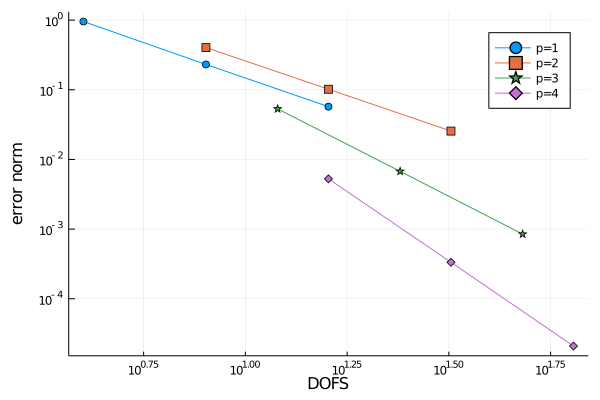

In [4]:
u(x) = sin(2*π*x[1])
ps = collect(1:4)
ncells = [ 2^i for i in 2:4 ]

eh1, ndofs, uhs = hp_refinement(u,ps,ncells)

function convergence_plot(ndofs,eh1,ps)
  plot(ndofs[1],eh1[1],label="p=$(ps[1])",shape=:auto)
  for i=2:length(ndofs)
    plot!(ndofs[i],eh1[i],label="p=$(ps[i])",shape=:auto)
  end
  plot!(xaxis=:log, yaxis=:log,
  shape=:auto,
  label=["H1_error"],
  xlabel="DOFS",ylabel="error norm")
end

convergence_plot(ndofs,eh1,ps)

Let us compute the slope for all these orders.
`funx` and `funy` determines the function we want to apply for the
$x$ and $y$ axis, e.g., log10, or identity.

In [5]:
function compute_slope(ndofs,error,funx,funy)
  slope = Float64[]
  for i in 1:length(ndofs)
    x = funx.(ndofs[i])
    y = funy.(error[i])
    linreg = hcat(fill!(similar(x), 1), x) \ y
    push!(slope,linreg[2])
  end
  return slope
end

compute_slope (generic function with 1 method)

In [6]:
slope = compute_slope(ndofs,eh1,log10,log10)

4-element Array{Float64,1}:
 -2.028993833006016
 -1.991312916369841
 -2.9862563281940377
 -3.986485239004138

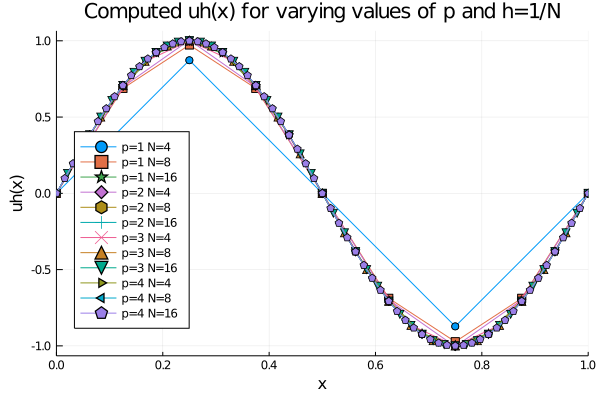

In [7]:
plot_uhs(uhs,ps,ncells)

**Answer:** For first order, we observe superconvergence, better convergence
than stated by theory. For higher orders, the computed order
of convergence is as stated by the theory.

Bounds can always be better than expected, known as
superconvergence. Some times, we can prove mathematically why it
happens for a particular mesh and discretisation method.

## Test 2

**Objective:** Check the error for linear finite elements with h-refinement.

**Description:** In the test, we want to show the error in terms of number of DOFs
using a log-log plot. We consider a family of meshes with
3, 6, 12, 24 cells in the domain $(0,1)$. The different with respect
to the previous test is the analytical solution we want. We have defined
the function as a piecewise function in $C^1([0,1])$ but not in
$C^2([0,1])$. The function is not in $H^2((0,1))$.

We compute the slope of the log-log plot using a linear regresion.

**Exercise 1:** Consider different orders, e.g., $p=1,2,3,4,5$. What do you
think about the numerical slope? Is it what we should expect from theory?

**Exercise 2:** Run the same code for meshes with 2, 4, 8, 16 cells.
What happens with the error? How can you explain it?

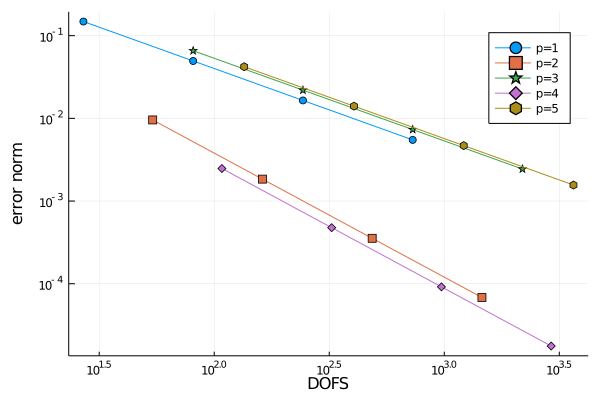

In [8]:
u(x) = x[1] > 0.5 ? 1+2*(x[1]-0.5)-8*(x[1]-0.5)^2 : 2*x[1]
ps = collect(1:5)
ncells = [3^i for i in 3:6]

eh1, ndofs, uhs = hp_refinement(u,ps,ncells)

convergence_plot(ndofs,eh1,ps)

In [9]:
slope = compute_slope(ndofs,eh1,log10,log10)

5-element Array{Float64,1}:
 -0.9998550265659496
 -1.4999200185214463
 -0.9993184558370285
 -1.4998190677082215
 -0.9996172718203487

In [10]:
plot_uhs(uhs,ps,ncells)

**Answer 1:** The results are as we expect from theory because the solution
is only in $H^1((0,1))$. Higher order methods cannot exploit any
smoothness. So, we cannot improve the slope, as predicted by the theory.

**Answer 2:** For this particular choice of the mesh, there is a point right
where the piecewise function changes. We can check that the exact
solution is in the finite element space. Thus, it is easy to check from
theory that with the Galerkin method we recover the exact solution (up to
errors related to linear solver, etc). Take a look at Cea's lemma,
the error is zero (for exact algebra).

## Test 3

**Objective:** Check the error for high order finite elements with
p-refinement.

**Description:** We consider the same problem as above for a mesh with 9 cells, and
compute the error for orders 1, 2, 3, 4. Since we fix the mesh and
increase the order, it is a p-refinement.

**Exercise:** What happens with the error?

In [11]:
u(x) = x[1] > 0.5 ? 1+2*(x[1]-0.5)-8*(x[1]-0.5)^2 : 2*x[1]
ps = 1:5
ncells = 9

function p_refinement(u,ps,ncells)
  eh1, ndofs, uhs = hp_refinement(u,ps,[ncells])
  eh1 = [eh1[i][1] for i in 1:length(eh1)]
  ndofs = [ndofs[i][1] for i in 1:length(ndofs)]
  uhs = [uhs[i][1] for i in 1:length(uhs)]
  return eh1, ndofs, uhs
end

eh1, ndofs, uhs = p_refinement(u,ps,ncells)

([0.44238204610293597, 0.04967594130929603, 0.1960773799900032, 0.012837775603673569, 0.12590052782377611], [9.0, 18.0, 27.0, 36.0, 45.0], Gridap.FESpaces.SingleFieldFEFunction{true}[SingleFieldFEFunction(), SingleFieldFEFunction(), SingleFieldFEFunction(), SingleFieldFEFunction(), SingleFieldFEFunction()])

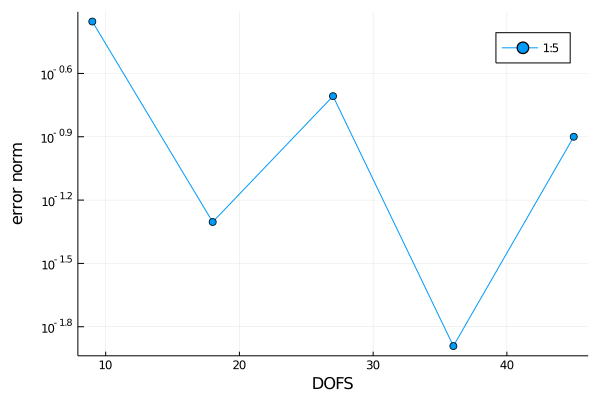

In [12]:
plot(ndofs,eh1,
     xaxis=:identity, yaxis=:log,
     label=1:length(ndofs),
     shape=:auto,
     xlabel="DOFS",ylabel="error norm")

In [13]:
slope = compute_slope([ndofs],[eh1],identity,log10)

1-element Array{Float64,1}:
 -0.018657735659759714

**Answer:** Since we cannot exploit smoothness, we do not improve the solution
increasing the order. We cannot see convergence!

## Test 4

**Objective:** Check the error for high order finite elements with
p-refinement for a smooth solution.

**Description:** We consider the same problem as above for a mesh with 9 cells, and
compute the error for orders 1, 2, 3, 4. Since we fix the mesh and
increase the order, it is a p-refinement. The difference is that now the
solution is very smooth $u(x) = \sin (2\pi x)$.

**Exercise:** What happens with the error?

In [14]:
u(x) = sin(2*π*x[1])
ps = 1:9
ncells = 4

eh1, ndofs, uhs = p_refinement(u,ps,ncells)

([0.9534508383389262, 0.4032852889679403, 0.053144946895484615, 0.0052605795910530126, 0.00041588626988614026, 2.7359014163730762e-5, 1.5410313441830905e-6, 7.58808758455431e-8, 3.5116279173466425e-9], [4.0, 8.0, 12.0, 16.0, 20.0, 24.0, 28.0, 32.0, 36.0], Gridap.FESpaces.SingleFieldFEFunction{true}[SingleFieldFEFunction(), SingleFieldFEFunction(), SingleFieldFEFunction(), SingleFieldFEFunction(), SingleFieldFEFunction(), SingleFieldFEFunction(), SingleFieldFEFunction(), SingleFieldFEFunction(), SingleFieldFEFunction()])

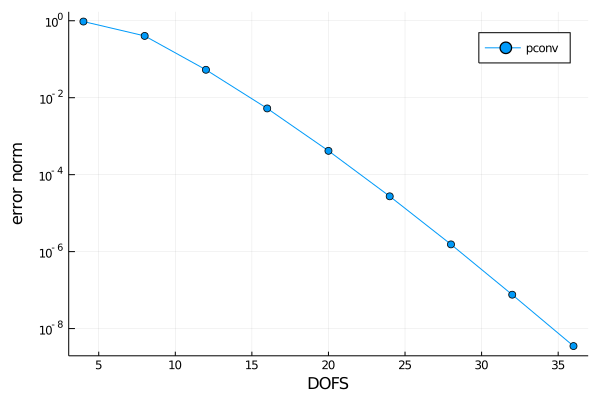

In [15]:
plot(ndofs,eh1,
     xaxis=:identity, yaxis=:log,
     label=:pconv,
     shape=:auto,
     xlabel="DOFS",ylabel="error norm")

In [16]:
slope = compute_slope([ndofs],[eh1],identity,log10)

1-element Array{Float64,1}:
 -0.2719618064369316

In [17]:
plot_uhs(uhs,ps,ncells)

MethodError: MethodError: no method matching getindex(::Gridap.FESpaces.SingleFieldFEFunction{true}, ::Int64)

**Answer:** p-refinement is an excellent choice, we have exponential
convergence! For smooth solutions, p-refinement is more cost effective
than h-refinement, exponential vs. algebraic convergence.

## Test 5

**Objective:** Check the error for high order finite elements with
h and p-refinement for a very oscillatory solution.

**Description:** We consider the same setting as in the previous test.
The difference is that now the
solution is very oscillatory $u(x) = \sin (64 \pi x)$.

**Exercise:** What happens with the error?

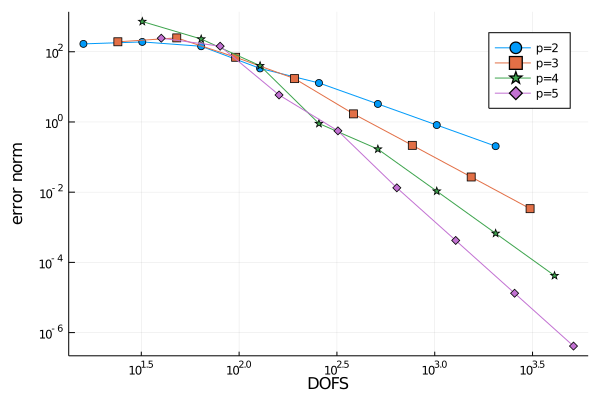

In [18]:
u(x) = sin(64*π*x[1])
ps = collect(2:5)
ncells = [2^i for i in 3:10]

eh1, ndofs, uhs = hp_refinement(u,ps,ncells)

convergence_plot(ndofs,eh1,ps)

In [19]:
slope = compute_slope(ndofs,eh1,log10,log10)

4-element Array{Float64,1}:
 -1.4863512605198506
 -2.4369322558912976
 -3.551147916328359
 -4.374886234348565

**Answer:** What we observe is the so-called pre-asymptotic behaviour. The
solution is so bad approximated for the coarsest meshes that we cannot
see the expected convergence. Once we have a mesh that can capture
the oscillations, we recover the expected convergence. Don't care about
the first points in a convergence analysis, they can behave in an
erratic way.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*